In [2]:
from pathlib import Path
import os
import sys
if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
from utils.crossvalidation import xval
from settings.paths import match_path, img_path, rf_path, bnn_path, flex_path
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocessing import create_bins, prep_data, rename_aper
from settings.columns import specz, calculate_colors, create_colors, list_feat
from utils.metrics import nmad, bias ,out_frac, rmse, mse
import warnings
import numpy as np
from utils.metrics import nmad, out_frac, bias, rmse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from utils.preprocessing import create_bins
from utils.crossvalidation import metric_per_bin
from utils.preprocessing import create_bins, prep_data, rename_aper

plt.rcParams["font.size"] = 22
blue = (0, 0.48, 0.70)
orange = (230/255,159/255, 0)
yellow = (0.94, 0.89, 0.26)
pink = (0.8, 0.47, 0.65)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = cycler('color', CB_color_cycle)

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


# Checking unWISE x Legacy dr10

In [6]:
data = pd.read_table("/home/mariko/Research/Projects/qucats_paper/data/referee/SPLUS_unWISE2_legacydr101_field_041.txt", sep=",")

In [7]:
#how many objects with unWISE match?
len(data.dropna(subset=["RAdeg"], inplace=False))

26790

In [8]:
#how many objects with Legacy match?
len(data.dropna(subset=["Separation"], inplace=False))

41349

In [9]:
l10_matches = data.dropna(subset=["Separation"], inplace=False)
unwise_matches = data.dropna(subset=["RAdeg"], inplace=False)

In [10]:
len(data)

51114

In [11]:
data.loc[data["FW1"]==0, "FW1"] = 0.001
data.loc[data["FW2"]==0, "FW2"] = 0.001

data["W1_MAG_unWISE"] = -2.5 * np.log10(data["FW1"]) + 22.5 +2.699
data["W2_MAG_unWISE"] = -2.5 * np.log10(data["FW2"]) + 22.5 +3.339
# data["e_W1_MAG"] = 2.5 * data["e_FW1"] / (data["FW1"] * np.log(10))
# data["e_W2_MAG"] = 2.5  * data["e_FW1"] / (data["FW2"] * np.log(10)) 

# insert missing value
data['W1_MAG_unWISE'].fillna(np.NaN, inplace=True)
data['W2_MAG_unWISE'].fillna(np.NaN, inplace=True)
data.loc[data["W1_MAG_unWISE"]>25, "W1_MAG_unWISE"] = np.NaN
data.loc[data["W2_MAG_unWISE"]>25, "W2_MAG_unWISE"] = np.NaN

data.loc[data["flux_w1"]==0, "flux_w1"] = 0.001
data.loc[data["flux_w2"]==0, "flux_w2"] = 0.001

data["W1_MAG_DESI"] = -2.5 * np.log10(data["flux_w1"]) + 22.5
data["W2_MAG_DESI"] = -2.5 * np.log10(data["flux_w2"]) + 22.5
# data["e_W1_MAG"] = 2.5 * data["e_FW1"] / (data["FW1"] * np.log(10))
# data["e_W2_MAG"] = 2.5  * data["e_FW1"] / (data["FW2"] * np.log(10)) 

# insert missing value
data['W1_MAG_DESI'].fillna(np.NaN, inplace=True)
data['W2_MAG_DESI'].fillna(np.NaN, inplace=True)
data.loc[data["W1_MAG_DESI"]>25, "W1_MAG_DESI"] = np.NaN
data.loc[data["W2_MAG_DESI"]>25, "W2_MAG_DESI"] = np.NaN

In [12]:
# W1

print(len(data.dropna(subset=["W1_MAG_unWISE"], inplace=False)))
print(len(data.dropna(subset=["W1_MAG_DESI"], inplace=False)))
print(len(data.dropna(subset=["W1_MAG_DESI"], inplace=False).dropna(subset=["W1_MAG_unWISE"], inplace=False)))

26688
38261
25958


In [13]:
print(l10_matches[l10_matches["W1_MAG_DESI"].isna()]["W1_MAG_unWISE"].isna().sum())
print()
print(l10_matches[~l10_matches["W1_MAG_DESI"].isna()]["W1_MAG_unWISE"].isna().sum())
print()
print(l10_matches[~l10_matches["W1_MAG_unWISE"].isna()]["W1_MAG_DESI"].isna().sum())

KeyError: 'W1_MAG_DESI'

In [ ]:
print(unwise_matches[unwise_matches["W1_MAG_DESI"].isna()]["W1_MAG_unWISE"].isna().sum())
print()
print(unwise_matches[~unwise_matches["W1_MAG_DESI"].isna()]["W1_MAG_unWISE"].isna().sum())
print()
print(unwise_matches[~unwise_matches["W1_MAG_unWISE"].isna()]["W1_MAG_DESI"].isna().sum())

22

80

730


/tmp/ipykernel_76555/3305023330.py:12: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kde = kde.gaussian_kde([matches_only["W1_MAG_unWISE"], matches_only["W1_MAG_unWISE"]-matches_only["W1_MAG_DESI"]])


(8.0, 22.0)

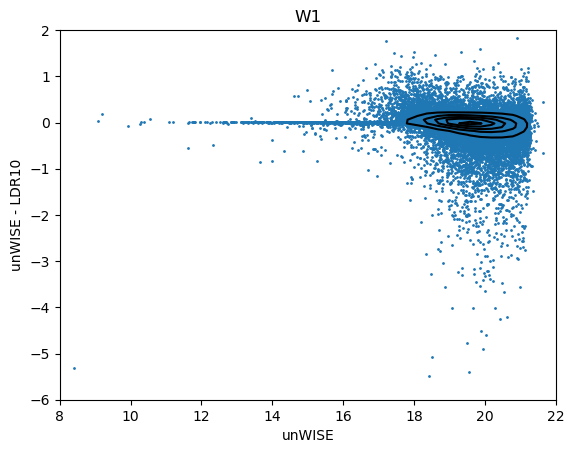

In [ ]:
import matplotlib.pyplot as plt

matches_only = data.dropna(subset=["W1_MAG_DESI"], inplace=False).dropna(subset=["W1_MAG_unWISE"], inplace=False)

plt.scatter(matches_only["W1_MAG_unWISE"], matches_only["W1_MAG_unWISE"]-matches_only["W1_MAG_DESI"], s=1)
plt.xlabel("unWISE")
plt.ylabel("unWISE - LDR10")
plt.title("W1")

# add contours
from scipy.stats import kde
kde = kde.gaussian_kde([matches_only["W1_MAG_unWISE"], matches_only["W1_MAG_unWISE"]-matches_only["W1_MAG_DESI"]])
xgrid = np.linspace(-8, 22, 100)
ygrid = np.linspace(-6, 2, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
Z = Z.reshape(Xgrid.shape)
CS = plt.contour(Xgrid, Ygrid, Z, levels=5, colors="black")
CS.collections[0].remove()
plt.xlim(8,22)



# GALEX non-observations

In [3]:
from utils.correct_extinction import correction
aper = "PStotal"

In [4]:
table = pd.read_table(os.path.join(match_path,"STRIPE82_DR4_DR16Q1a_unWISE2a_GALEXDR672a.csv"), sep=",")
table = rename_aper(table)

In [9]:
print(len(table["name"]))
print(len(table.dropna(subset=["name"], inplace=False)))

37978
10455


In [23]:
galex_obs = table.dropna(subset=["name"], inplace=False)
non_obs = table[table["name"].isna()]


27523 10455


# Tests

In [3]:
pd.read_table("/home/mariko/Research/Projects/qucats_paper/data/crossmatch/STRIPE82_DR4_DR16Q1a_unWISE2a_GALEXDR672a.csv", sep=",")

,ID,PHOT_ID_dual_1,RA_1,DEC_1,A,B,KRON_RADIUS,FWHM_n,MU_MAX_INST,ISOarea,...,primid,groupid,Gd,Nd,primidd,groupidd,grouptot,OName,Size,angDist_x
0,b'iDR4_3_STRIPE82-0044_0000186 ...,b'iDR4_3_STRIPE82-0044_dual_0000186 ...,29.157186,0.036686,0.000185,0.000161,4.418086,0.965081,18.746910,3.034337e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b'iDR4_3_STRIPE82-0044_0000279 ...,b'iDR4_3_STRIPE82-0044_dual_0000279 ...,29.346369,0.039853,0.000167,0.000140,5.339382,0.979935,19.640038,1.633874e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'iDR4_3_STRIPE82-0044_0000284 ...,b'iDR4_3_STRIPE82-0044_dual_0000284 ...,30.190632,0.040137,0.000162,0.000123,1.820000,1.425208,19.901010,9.336420e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'iDR4_3_STRIPE82-0044_0000362 ...,b'iDR4_3_STRIPE82-0044_dual_0000362 ...,28.995541,0.042112,0.000188,0.000146,5.601652,0.946742,18.901420,2.100695e-07,...,6.380380e+18,6380380368759947800+6380380379497370100,1.0,2.0,6.380380e+18,6380380368759947800+6380380379497370100,6380380368759947800+6380380379497370100,N,0.0,0.863697
4,b'iDR4_3_STRIPE82-0044_0000395 ...,b'iDR4_3_STRIPE82-0044_dual_0000395 ...,29.374085,0.042780,0.000222,0.000190,4.289654,0.989299,17.395239,4.434800e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37973,b'iDR4_3_STRIPE82-0105_0074056 ...,b'iDR4_3_STRIPE82-0105_dual_0074056 ...,313.233758,-0.219212,0.000211,0.000187,5.257678,1.221635,19.408695,2.567515e-07,...,6.379430e+18,6379430473391673559,0.0,1.0,6.379430e+18,6379430473391673559,6379430473391673559,N,0.0,1.410358
37974,b'iDR4_3_STRIPE82-0105_0075952 ...,b'iDR4_3_STRIPE82-0105_dual_0075952 ...,313.006729,0.014315,0.000271,0.000246,4.077143,1.030742,17.196903,1.120370e-06,...,6.379430e+18,6379430462656349717+6379430473393771476,1.0,2.0,6.379430e+18,6379430462656349717+6379430473393771476,6379430462656349717+6379430473393771476,N,0.0,0.589719
37975,b'iDR4_3_STRIPE82-0105_0076570 ...,b'iDR4_3_STRIPE82-0105_dual_0076570 ...,313.227521,0.014055,0.000246,0.000203,3.642726,1.000247,18.232796,5.835263e-07,...,6.379430e+18,6379430472317928415,0.0,1.0,6.379430e+18,6379430472317928415,6379430472317928415,N,0.0,0.356868
37976,b'iDR4_3_STRIPE82-0105_0078888 ...,b'iDR4_3_STRIPE82-0105_dual_0078888 ...,313.546810,-0.043118,0.000233,0.000197,3.784242,1.037211,18.519672,5.135031e-07,...,6.379430e+18,6379430472320025337,0.0,1.0,6.379430e+18,6379430472320025337,6379430472320025337,N,0.0,0.577590
